In [ ]:
!pip install kagglehub

## Github link: https://github.com/SeanHGorman/DTSA5509

# Project - Predicting Heart Failure Risk Using Supervised Machine Learning

In [ ]:
## Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
# Download latest version
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")
print("Path to dataset files:", path)

## Import dataset downloaded locally from Kaggle
dataset = pd.read_csv("heart.csv")




Path to dataset files: /home/hexuser/.cache/kagglehub/datasets/fedesoriano/heart-failure-prediction/versions/1


In [ ]:
## Verify that the dataset has been uploaded correctly. 

dataset.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
## Transpose and describe the dataset to inspect
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


### Check for null values
Even though the count matches up between each column in the dataframe, we'll use a heatmap to check for any missing data

<Axes: >

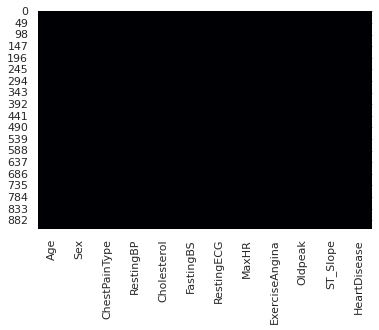

In [ ]:
# Heatmap to visualize any missing data
sns.heatmap(dataset.isnull(),cmap = 'magma',cbar = False);

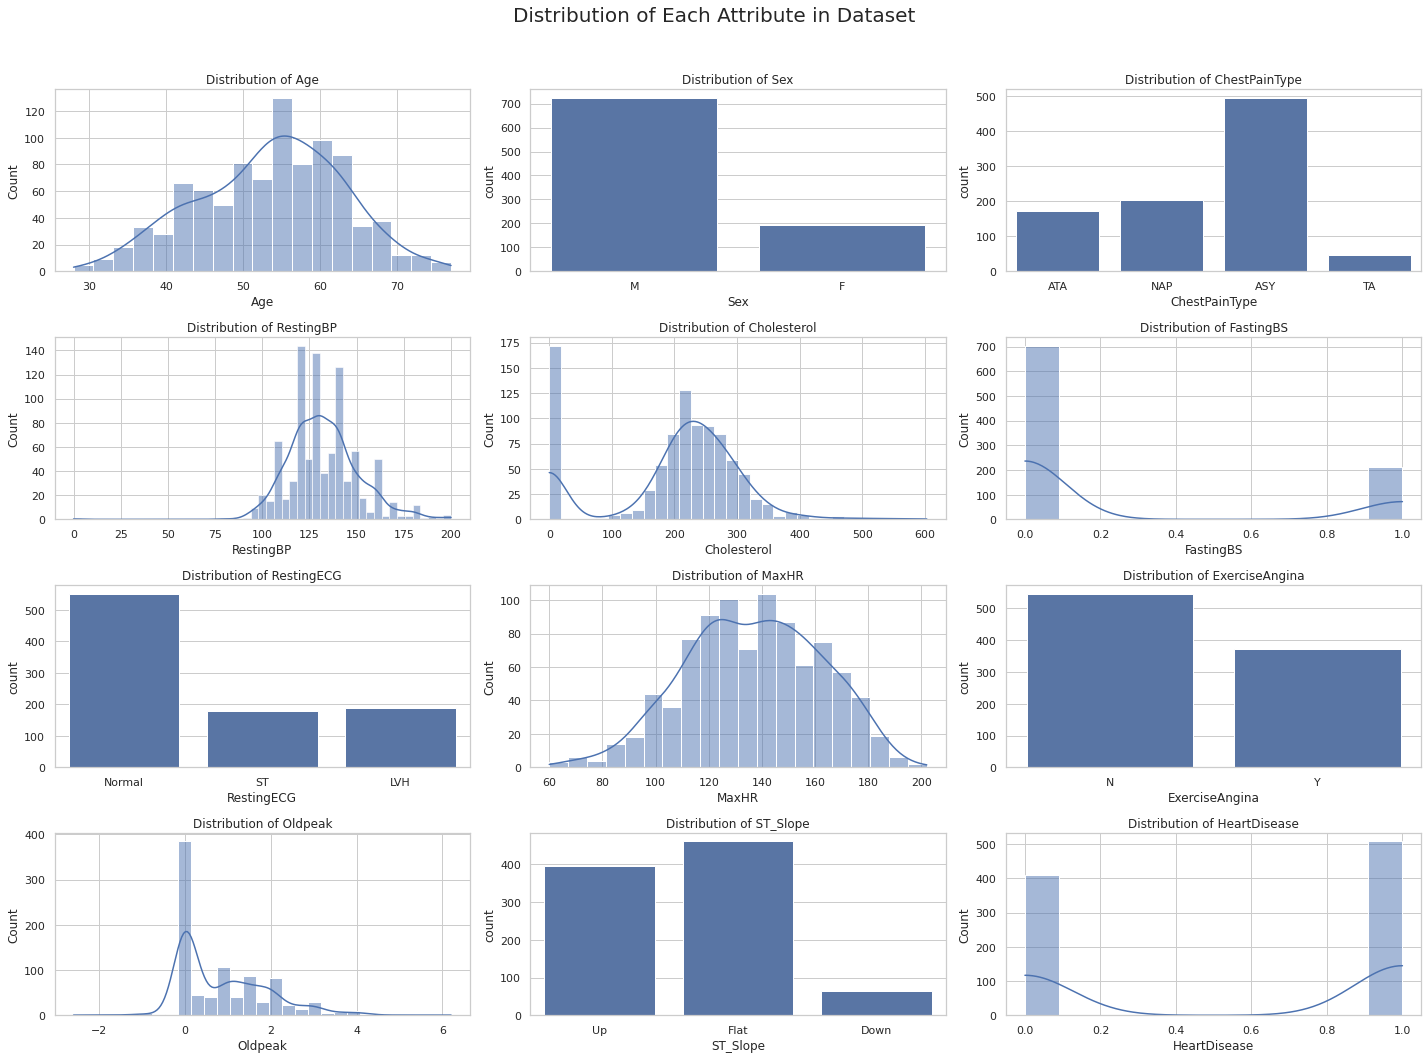

In [ ]:


# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
fig.suptitle("Distribution of Each Attribute in Dataset", fontsize=20)

# List of columns to plot
columns = dataset.columns

# Plot each attribute
for ax, column in zip(axes.flatten(), columns):
    if dataset[column].dtype == "object":
        sns.countplot(x=column, data=dataset, ax=ax)
    else:
        sns.histplot(dataset[column], kde=True, ax=ax)
    ax.set_title(f"Distribution of {column}")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

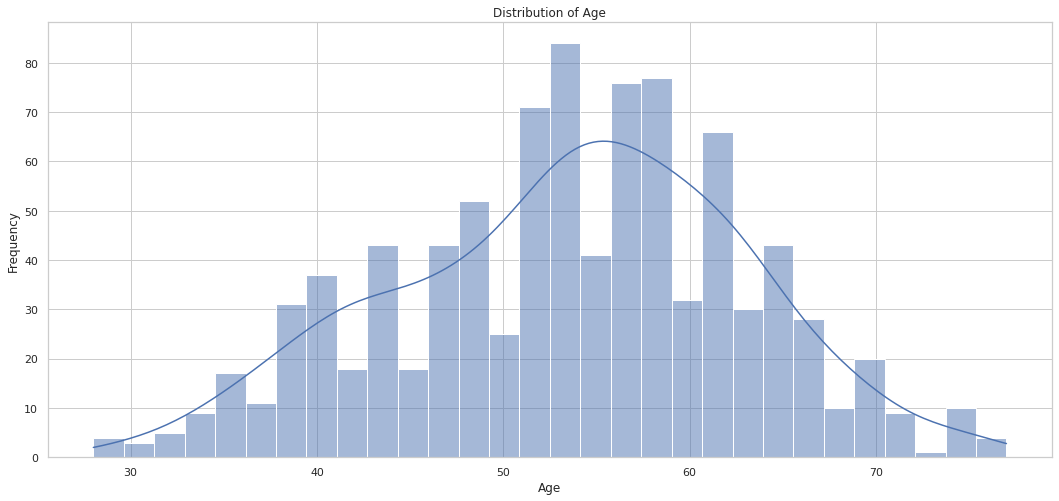

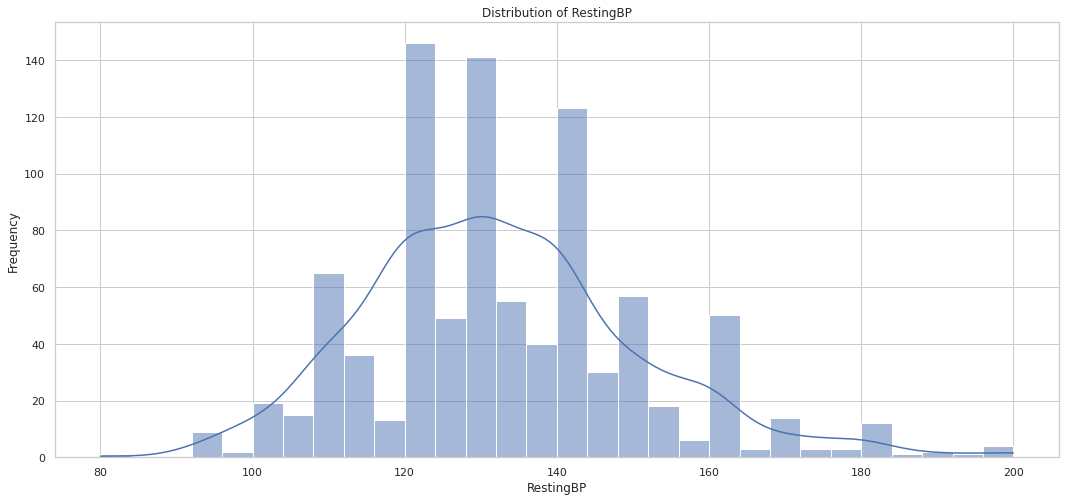

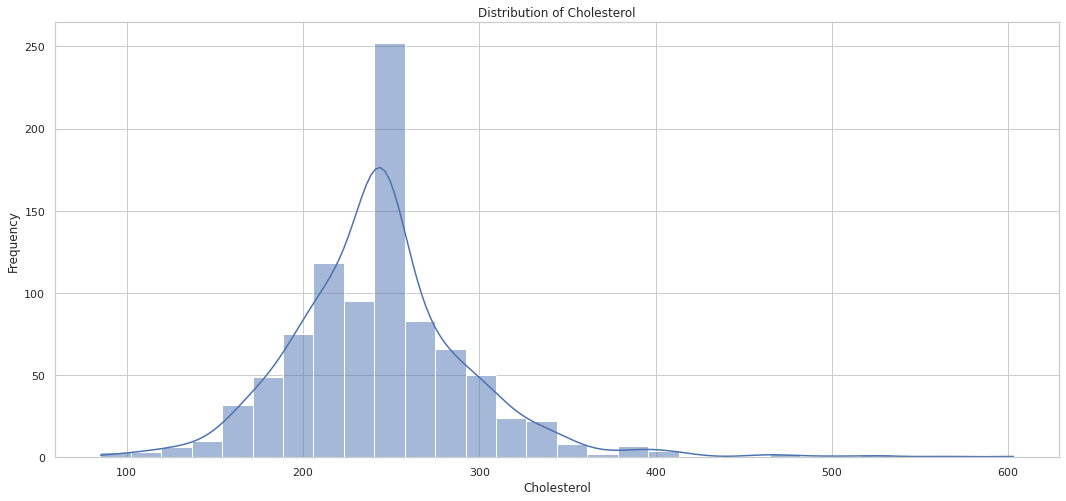

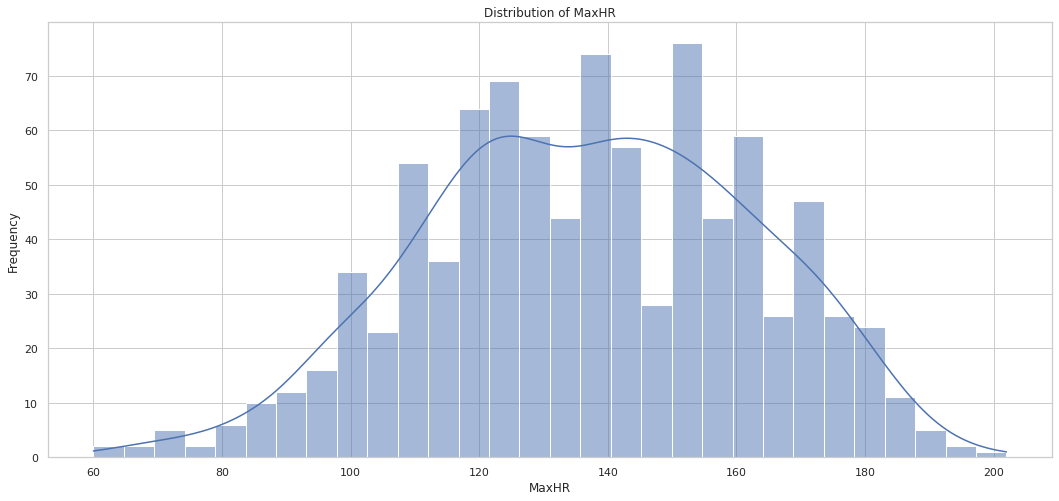

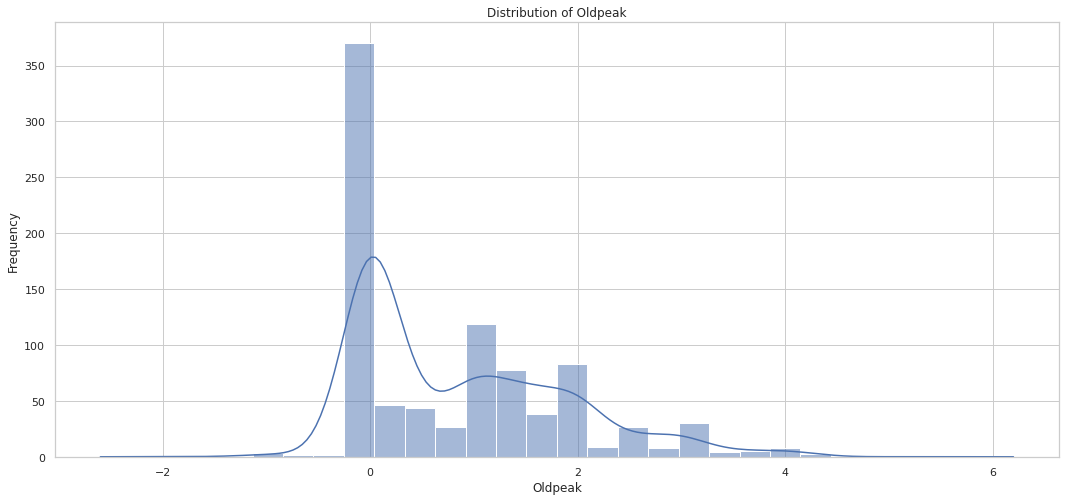

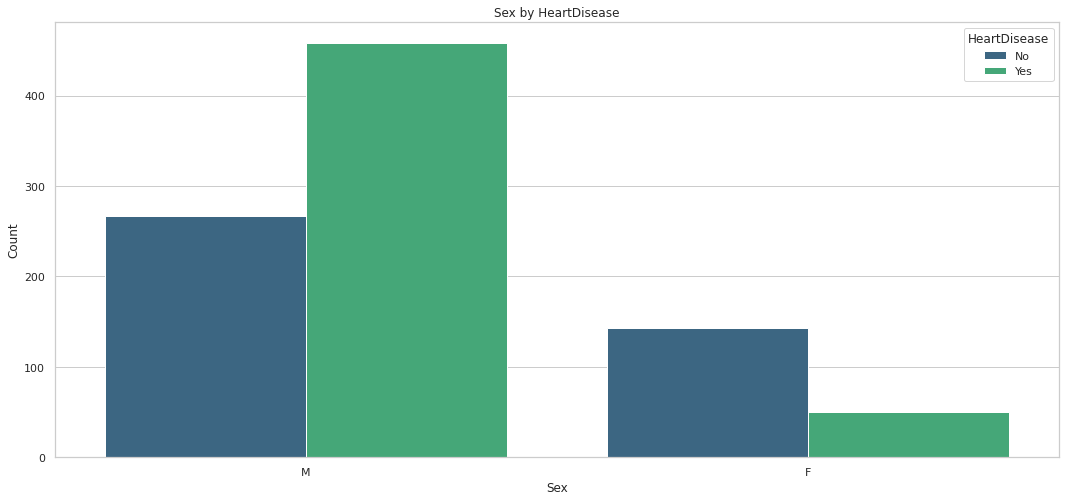

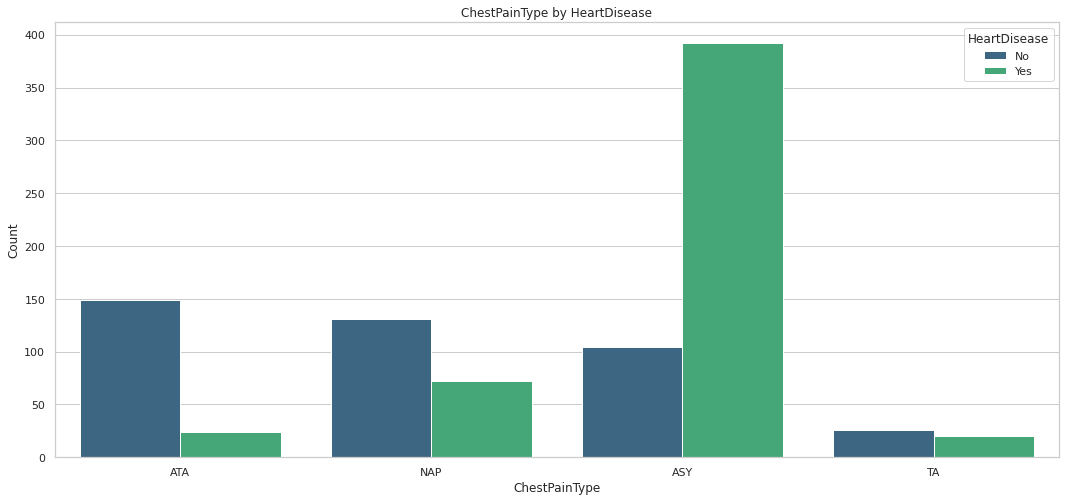

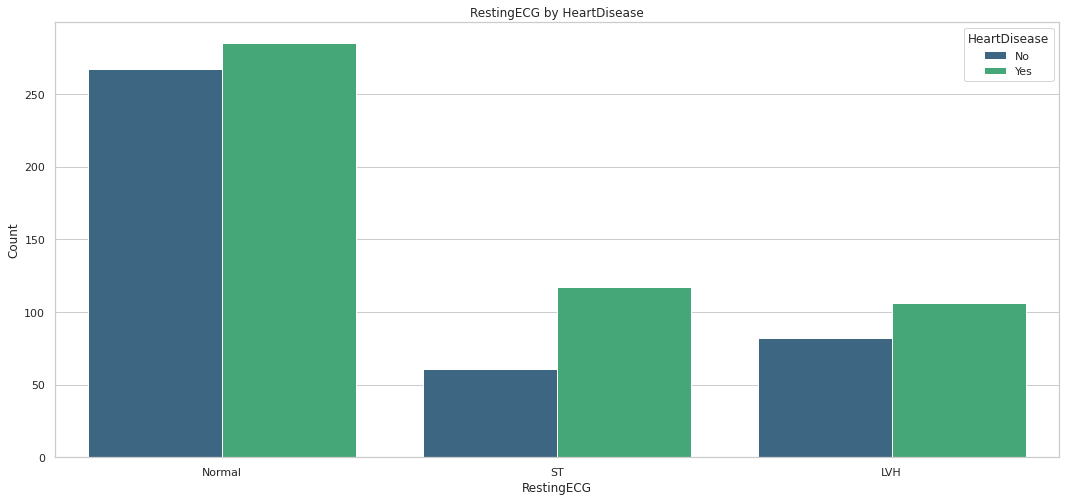

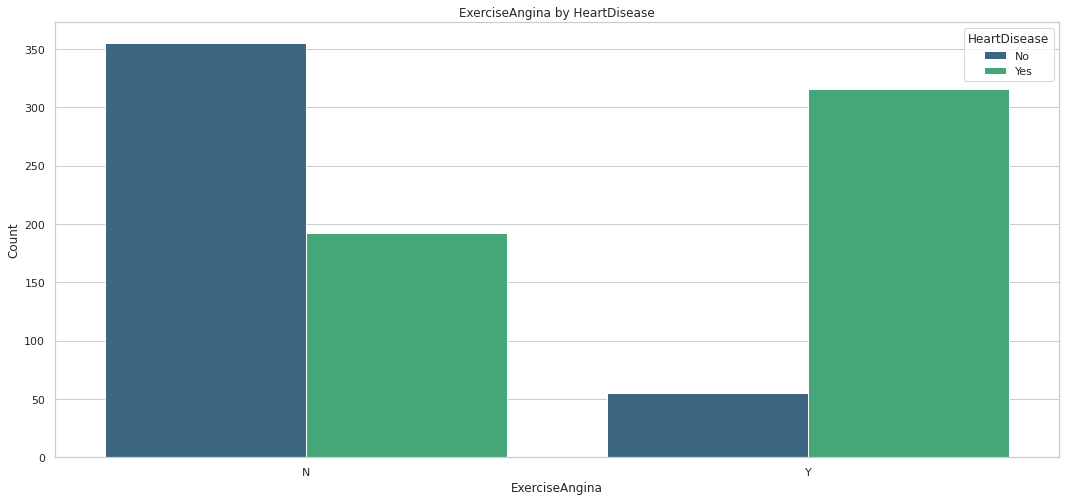

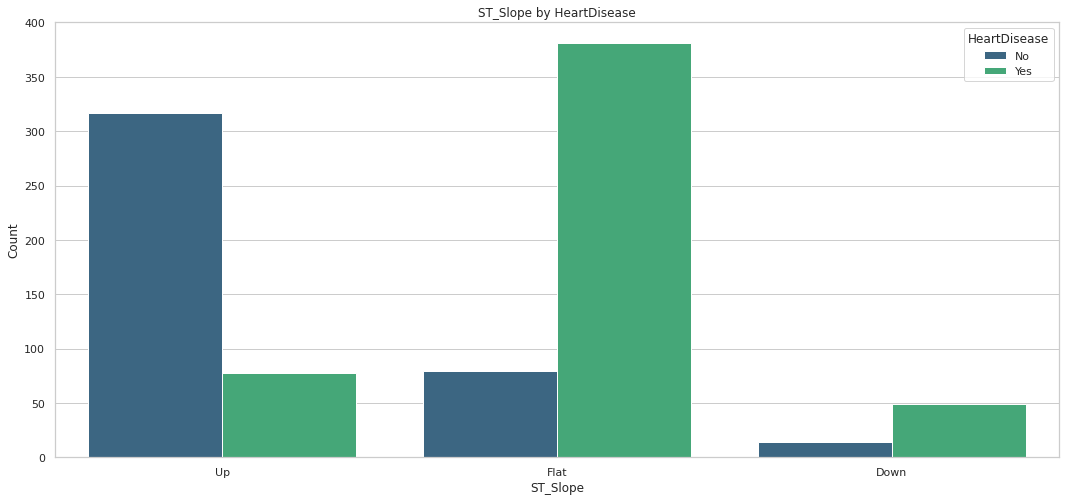

In [ ]:
## Data Cleaning and Preprocessing
# Identify numerical and categorical columns
numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
target_column = 'HeartDisease'

# Distribution plots for numerical columns
for col in numerical_columns:
    plt.figure(figsize=(18, 8))
    sns.histplot(dataset[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Bar plots for categorical columns
for col in categorical_columns:
    plt.figure(figsize=(18, 8))
    sns.countplot(x=dataset[col], hue=dataset['HeartDisease'], palette='viridis')
    plt.title(f'{col} by HeartDisease')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='HeartDisease', labels=['No', 'Yes'])
    plt.show()

<Axes: title={'center': 'Distribution of Cholesterol'}, xlabel='Cholesterol', ylabel='Count'>

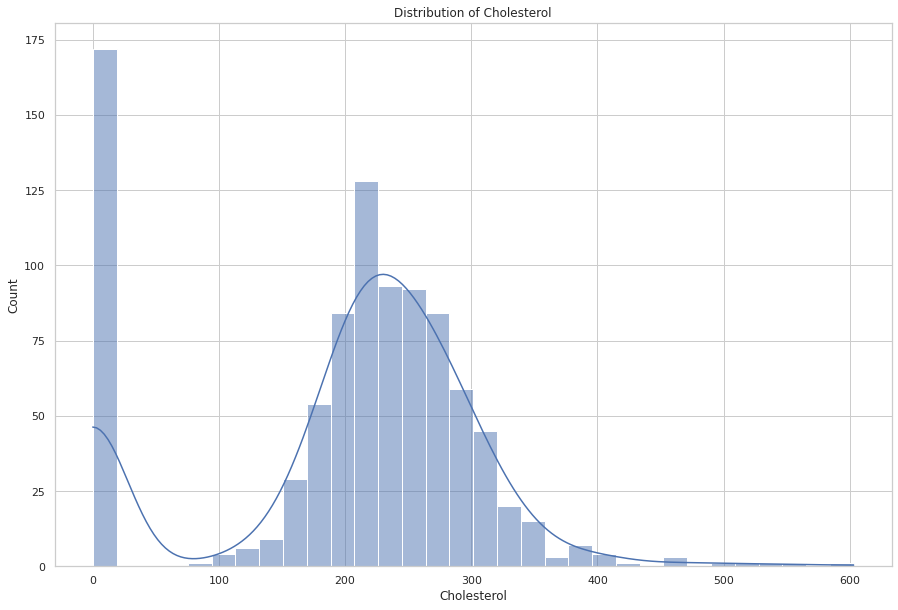

In [ ]:
plt.figure(figsize = (15,10))
#help(sns.countplot)
plt.title("Distribution of Cholesterol")
sns.histplot(data=dataset, x = "Cholesterol", kde = True)

<Axes: title={'center': 'RestingBP'}, xlabel='RestingBP', ylabel='Count'>

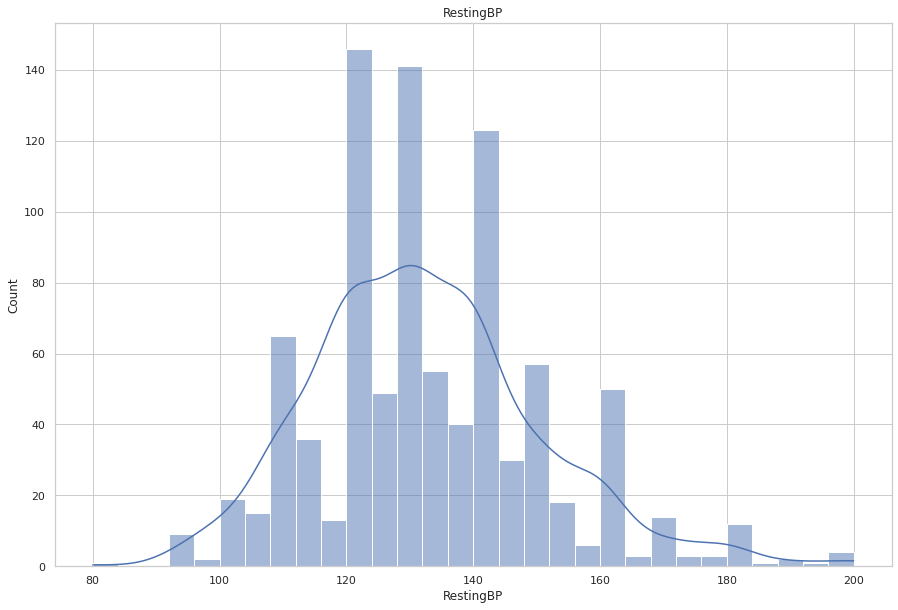

In [ ]:
plt.figure(figsize = (15,10))
#help(sns.countplot)
plt.title("RestingBP")
sns.histplot(data=dataset, x = "RestingBP", kde = True)

In [ ]:
dataset[['RestingBP', 'Cholesterol']].loc[dataset['RestingBP'] == 0]

,RestingBP,Cholesterol
449,0,0


<Axes: title={'center': 'Distribution of Cholesterol'}, xlabel='Cholesterol', ylabel='Count'>

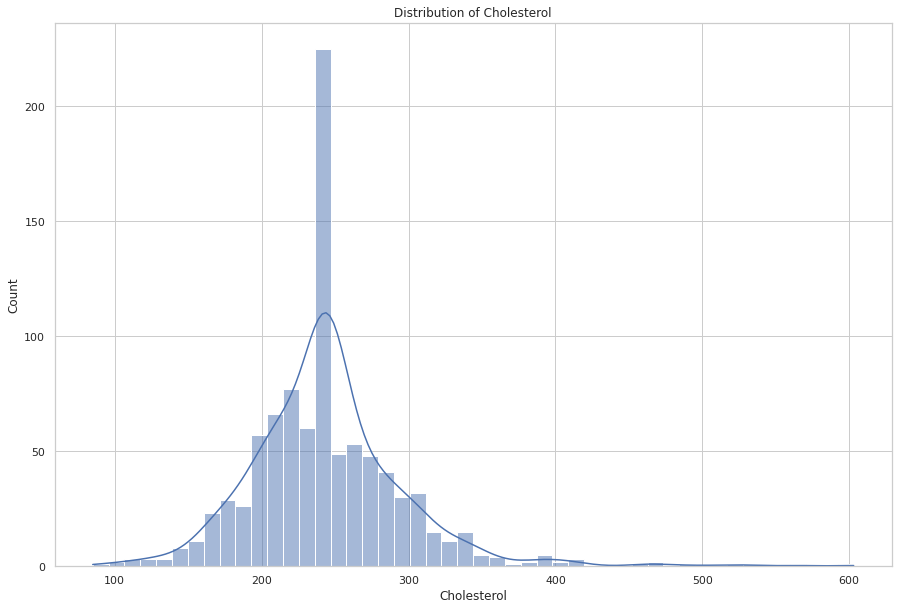

In [ ]:
# Handle invalid values
dataset.loc[dataset['Cholesterol'] == 0, 'Cholesterol'] = np.nan
dataset.loc[dataset['RestingBP'] == 0, 'RestingBP'] = np.nan

# Fill missing values
dataset[numerical_columns] = dataset[numerical_columns].fillna(dataset[numerical_columns].mean())
dataset[categorical_columns] = dataset[categorical_columns].fillna(dataset[categorical_columns].mode().iloc[0])

# Correlation Plot Including Encoded Categorical Features
# One-hot encode categorical columns
encoded_data = pd.get_dummies(dataset[categorical_columns])
combined_data = pd.concat([dataset[numerical_columns], encoded_data], axis=1)




plt.figure(figsize = (15,10))
#help(sns.countplot)
plt.title("Distribution of Cholesterol")
sns.histplot(data=combined_data, x = "Cholesterol", kde = True)

hex_cell_4551d543-a79f-4423-ad41-5648f14c40f0.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  


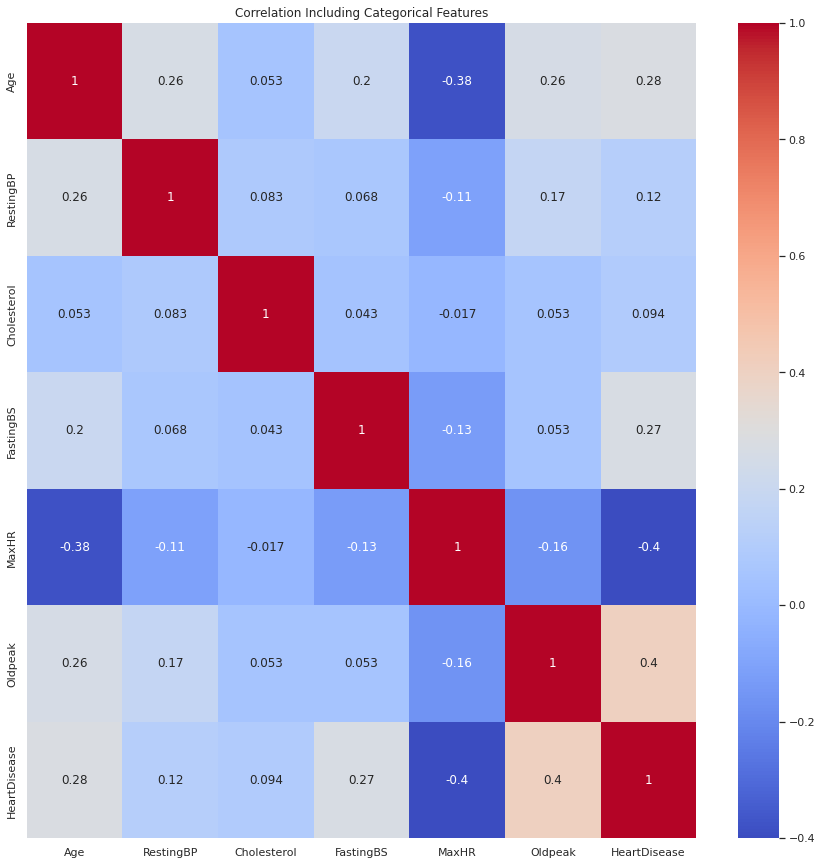

In [ ]:



# Plot correlation
plt.figure(figsize=(15, 15))
sns.heatmap(dataset.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Including Categorical Features")
plt.show()


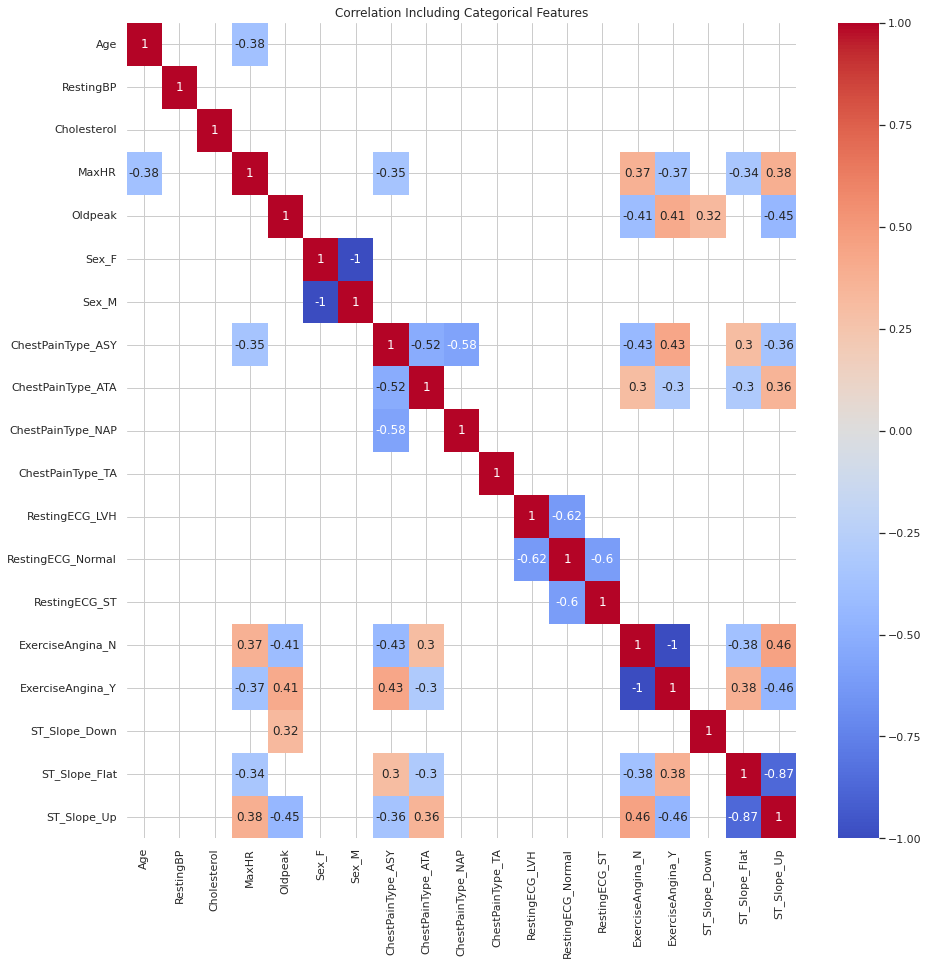

In [ ]:


# Plot correlation
corr = combined_data.corr()
mask = (corr < -0.3) | (corr > 0.3)
plt.figure(figsize=(15, 15))
sns.heatmap(corr, cmap="coolwarm", mask=~mask, annot=True)
plt.title("Correlation Including Categorical Features")
plt.show()


In [ ]:
# Split dataset into train and test sets
X = dataset[numerical_columns + categorical_columns]
y = dataset[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=111)

# Define preprocessing pipeline
numerical_pipeline = Pipeline([('scaler', StandardScaler())])
categorical_pipeline = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_columns),
    ('cat', categorical_pipeline, categorical_columns)
])

# Define model pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=111))
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[71 11]
 [ 9 93]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        82
           1       0.89      0.91      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



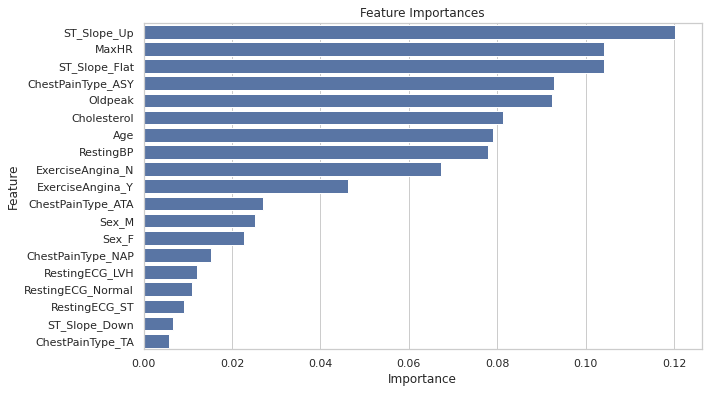

In [ ]:
# Extract feature importances
feature_importances = model_pipeline.named_steps['classifier'].feature_importances_
feature_names = preprocessor.transformers_[0][2] + list(preprocessor.transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_columns))

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
# Random Forest Model
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

# Logistic Regression Model
logistic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])
logistic_pipeline.fit(X_train, y_train)
y_pred_logistic = logistic_pipeline.predict(X_test)

# Gradient Boosting Model
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])
gb_pipeline.fit(X_train, y_train)
y_pred_gb = gb_pipeline.predict(X_test)

# Evaluate Models
rf_accuracy = accuracy_score(y_test, y_pred_rf)
logistic_accuracy = accuracy_score(y_test, y_pred_logistic)
gb_accuracy = accuracy_score(y_test, y_pred_gb)

print("Random Forest Accuracy:", rf_accuracy)
print("Logistic Regression Accuracy:", logistic_accuracy)
print("Gradient Boosting Accuracy:", gb_accuracy)

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic))

print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))


Random Forest Accuracy: 0.8967391304347826
Logistic Regression Accuracy: 0.8695652173913043
Gradient Boosting Accuracy: 0.907608695652174

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        82
           1       0.86      0.91      0.89       102

    accuracy                           0.87       184
   macro avg       0.87      0.86      0.87       184
weighted avg       0.87      0.87      0.87       184


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90        82
           1       0.91      0.92      0.92       102

    accuracy                           0.91       184
   macro avg       0.91      0.91      0.91       184
weighted avg       0.91      0.91      0.91       184

